In [146]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [147]:
# import weather data of Montgomery county of Ohio
weather_df = pd.read_csv('datasets/Montgomery_weather.csv', parse_dates=['time_iso']).set_index('time_iso', drop=True)

In [148]:
print(f'Number of weather data points: {len(weather_df)}')
weather_df.head()

Number of weather data points: 167088


,name,lat,lon,time,cloud_cover,cloud_height,dew_point,evaporation,hourly_precipitation,mean_evaporation_rate,...,pressure,soil_temperature,temperature,u_wind,v_wind,volumetric_soil_water,wind_angle,wind_direction,wind_gust,wind_speed
time_iso,,,,,,,,,,,,,,,,,,,,,
2004-12-31 00:00:00,Location #2,39.7439,-84.292534,1104451200,1.00000,712.836487,5.282800,0.000059,0.082016,0.000016,...,1021.724375,-0.088904,7.471643,0.249939,5.510193,0.436255,183,s,10.405787,5.515858
2004-12-31 01:00:00,Location #2,39.7439,-84.292534,1104454800,1.00000,1398.871460,5.731348,0.000066,0.020027,0.000018,...,1021.066875,-0.029944,7.925134,0.525436,5.933640,0.435238,185,s,11.391105,5.956858
2004-12-31 02:00:00,Location #2,39.7439,-84.292534,1104458400,1.00000,1535.676025,5.920435,0.000061,0.018120,0.000017,...,1020.855000,0.472498,8.582147,0.690948,6.352829,0.435644,186,s,12.133898,6.390293
2004-12-31 03:00:00,Location #2,39.7439,-84.292534,1104462000,0.99411,1439.023438,6.182214,0.000047,0.005245,0.000013,...,1020.400000,1.450861,9.710901,0.856064,6.947968,0.436858,187,s,13.199970,7.000507
2004-12-31 04:00:00,Location #2,39.7439,-84.292534,1104465600,1.00000,3621.580566,6.465479,0.000035,0.063419,0.000010,...,1020.146250,1.639673,10.182764,1.645004,6.894165,0.434775,193,s,14.804124,7.087704


In [149]:
weather_df.columns

Index(['name', 'lat', 'lon', 'time', 'cloud_cover', 'cloud_height',
       'dew_point', 'evaporation', 'hourly_precipitation',
       'mean_evaporation_rate', 'mean_potential_evaporation_rate',
       'potential_evaporation', 'precipitation_type', 'pressure',
       'soil_temperature', 'temperature', 'u_wind', 'v_wind',
       'volumetric_soil_water', 'wind_angle', 'wind_direction', 'wind_gust',
       'wind_speed'],
      dtype='object')

In [150]:
# drop unnecessary columns
weather_df = weather_df.drop(columns=['time', 'name', 'lat', 'lon'])

In [151]:
# count the number of nulls in each column
weather_df.isna().sum()

cloud_cover                            0
cloud_height                       35004
dew_point                              0
evaporation                            0
hourly_precipitation                   0
mean_evaporation_rate                  0
mean_potential_evaporation_rate        0
potential_evaporation                  0
precipitation_type                     0
pressure                               0
soil_temperature                       0
temperature                            0
u_wind                                 0
v_wind                                 0
volumetric_soil_water                  0
wind_angle                             0
wind_direction                         0
wind_gust                              0
wind_speed                             0
dtype: int64

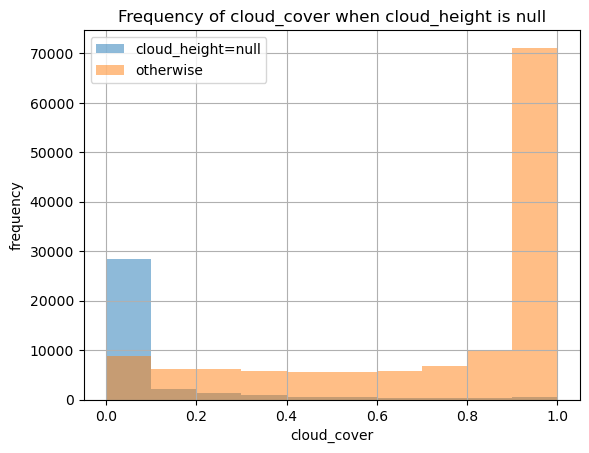

In [152]:
# Check why there are null values for cloud_height

weather_df[weather_df['cloud_height'].isna()==True]['cloud_cover'].hist(alpha=0.5)
weather_df[weather_df['cloud_height'].isna()==False]['cloud_cover'].hist(alpha=0.5)
plt.title('Frequency of cloud_cover when cloud_height is null')
plt.xlabel('cloud_cover')
plt.ylabel('frequency')
plt.legend(['cloud_height=null', 'otherwise'])

As we see above, when cloud_height is null, cloud_cover is mostly 0. Therefore, we could assume that cloud_height is null because there were no (or barely) clouds. Because the null value cannot be fed into some machine learning models, the null value should be replaced with another value. Those will be replaced with the most frequent cloud_height(not null) values when cloud_cover is around 0.

In [153]:
# impute null values
from sklearn.impute import SimpleImputer

imp_nan = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

cloud_height_with_zero_cloud_cover = weather_df[(weather_df['cloud_cover']==0)&(weather_df['cloud_height'].notna())]
most_fre_cloud_height = cloud_height_with_zero_cloud_cover['cloud_height'].value_counts().keys()[0]

weather_df['cloud_height'] = weather_df['cloud_height'].fillna(most_fre_cloud_height)

In [154]:
# recheck existence of null values
weather_df['cloud_height'].isna().sum()

0

In [155]:
# check categorical data to label those using numeric values
list(set(weather_df.columns)-set(weather_df.describe().columns))

['wind_direction']

In [156]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

label = le.fit_transform(weather_df['wind_direction'])

weather_df['wind_direction'] = label

In [157]:
# crate time featues

def create_features(df):

  temp_df = df.copy(deep=True)

  temp_df['hour'] = temp_df.index.hour
  temp_df['dayofweek'] = temp_df.index.dayofweek
  temp_df['quarter'] = temp_df.index.quarter
  temp_df['month'] = temp_df.index.month
  temp_df['year'] = temp_df.index.year
  temp_df['dayofyear'] = temp_df.index.dayofyear
  temp_df['weekofyear'] = temp_df.index.weekofyear
  temp_df['dayofmonth'] = temp_df.index.day
  temp_df['weekofyear'] = temp_df.index.isocalendar().week

  return temp_df

weather_df_modified = create_features(weather_df)

/var/folders/1v/cyx67vkj1r3bwgnv9l4t23vh0000gn/T/ipykernel_50812/4136270823.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  temp_df['weekofyear'] = temp_df.index.weekofyear


In [158]:
# load electrocity load data
load_data = pd.read_csv('datasets/DAYTON_hourly.csv', parse_dates=['Datetime']).set_index('Datetime', drop=True)

# merge weather data and electrocity data
weather_load_df = weather_df_modified.merge(load_data, how='inner', left_index=True, right_index=True)

In [159]:
#final form of dataset
weather_load_df.head()

,cloud_cover,cloud_height,dew_point,evaporation,hourly_precipitation,mean_evaporation_rate,mean_potential_evaporation_rate,potential_evaporation,precipitation_type,pressure,...,wind_speed,hour,dayofweek,quarter,month,year,dayofyear,weekofyear,dayofmonth,DAYTON_MW
2004-12-31 00:00:00,1.00000,712.836487,5.282800,0.000059,0.082016,0.000016,9.387732e-07,0.000003,1.0,1021.724375,...,5.515858,0,4,4,12,2004,366,53,31,1722.0
2004-12-31 01:00:00,1.00000,1398.871460,5.731348,0.000066,0.020027,0.000018,-7.431954e-07,-0.000003,1.0,1021.066875,...,5.956858,1,4,4,12,2004,366,53,31,1596.0
2004-12-31 02:00:00,1.00000,1535.676025,5.920435,0.000061,0.018120,0.000017,-4.253816e-07,-0.000002,1.0,1020.855000,...,6.390293,2,4,4,12,2004,366,53,31,1517.0
2004-12-31 03:00:00,0.99411,1439.023438,6.182214,0.000047,0.005245,0.000013,-7.010531e-07,-0.000003,0.0,1020.400000,...,7.000507,3,4,4,12,2004,366,53,31,1486.0
2004-12-31 04:00:00,1.00000,3621.580566,6.465479,0.000035,0.063419,0.000010,-8.833595e-07,-0.000003,1.0,1020.146250,...,7.087704,4,4,4,12,2004,366,53,31,1469.0
